In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
cancer = load_breast_cancer()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target)

In [ ]:
#분리(split)한 뒤에 스케일 조정해야함
scaler = MinMaxScaler()
scaler.fit(X_train) #학습데이터 기준으로 스케일러를 맞춤

MinMaxScaler()

In [9]:
# 스케일러는 밖에 따로 둬야함
X_train_scaled = scaler.transform(X_train)

# 찐시작

In [ ]:
# 거리기반 모델(KNN)을 사용할 떄 MinMaxScaler를 쓰면 데이터가 모이기 때문에 적합하지 않음 -> StandardScaler 사용: 평균, 분산 활용
# KNN에 Standard를 사용해 스케일 조정 후에 학습을 진행하세요
# 1. 데이터 -> cancer 데이터
# 2. 나누기 -> train/test
# 3. 스케일 => StandardScaler
# 4. 학습 -> fit, predict
# 5. 검증 -> score..

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

plt.rcParams['font.family'] = 'Malgun Gothic' #한글은 '-', 지수가 안나옴
plt.rcParams['axes.unicode_minus'] = False 
# 터미널 'pip freeze > requirements.txt'(>: 해당데이터를 오른쪽 파일에 담기)

In [ ]:
# 1. 데이터 -> cancer 데이터
cancer = load_breast_cancer()

malignant: 0.37258347978910367
benign: 0.6274165202108963


In [ ]:
# tip1. split 하기전에 가능하면 분포를 확인하세요.(한쪽에 쏠려있는지) -->'포레스트 레포'에 나옴----------?
unique, counts = np.unique(cancer.target, return_counts=True)
for i, (val, count) in enumerate(zip(unique, counts)):
    print(f'{cancer.target_names[val]}: {count/len(cancer.target)}')

In [ ]:
# 2. 나누기 -> train/test
# 분포가 한쪽에 쏠리면, stratify를 사용해서 균등하게 맞추세요.
X_train, X_test, y_train, y_test = train_test_split(cancer.data, 
                                                    cancer.target, 
                                                    stratify=cancer.target, # ❗머신러닝은 랜덤이 제일 좋지만 좀 포기하고 + 과적합위험이 있지만 -> 한쪽에 쏠리는걸 막을 수 있음 
                                                    random_state=42) 

## 스케일러 선택법
1. Standard vs. MinmaxScaler
2. 이상치가 있다면 RobustScaler

## load_breast_cancer()와 나이브 베이즈를 사용해서 최적의 스케일러는? 

- 나이브베이즈는 확률, 통계
- minmax / standard / 아무것도 x

결론: 뭘하든 다를게 없다

In [71]:
# minmax / standard / 아무것도 x
scalers = {
    'None' : None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()
}

In [ ]:
#결과값 비교
scaling_results = {}
for name, scaler in scalers.items():
    if scaler is not None:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    gnb = GaussianNB()
    gnb.fit(X_train_scaled, y_train)

    y_pred = gnb.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    scaling_results[name] = {'accuracy': accuracy}

In [76]:
scaling_results

{'None': {'accuracy': 0.9370629370629371},
 'StandardScaler': {'accuracy': 0.9370629370629371},
 'MinMaxScaler': {'accuracy': 0.9370629370629371}}

## KNN과 StandardScaler
- KNN은 거리기반이어서 Minmax가 맞지않음

In [61]:
# 3. 스케일 => StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
training_accuracy = []
test_accuracy = []
neighbors_settings = range(2, 31)

In [63]:
# 파이프라인으로 간단하게 할 수 있음
for n_neighbors in neighbors_settings:
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(X_train_scaled, y_train)

    train_acc = knn.score(X_train_scaled, y_train)
    test_acc = knn.score(X_test_scaled, y_test)

    training_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

In [64]:
best_k = neighbors_settings[np.argmax(test_accuracy)] #argmax: 인덱스줌
best_test_acccuracy = max(test_accuracy)
best_k, best_test_acccuracy # [2, 3, 4, 5, 6, 7, 8]

(5, 0.9790209790209791)

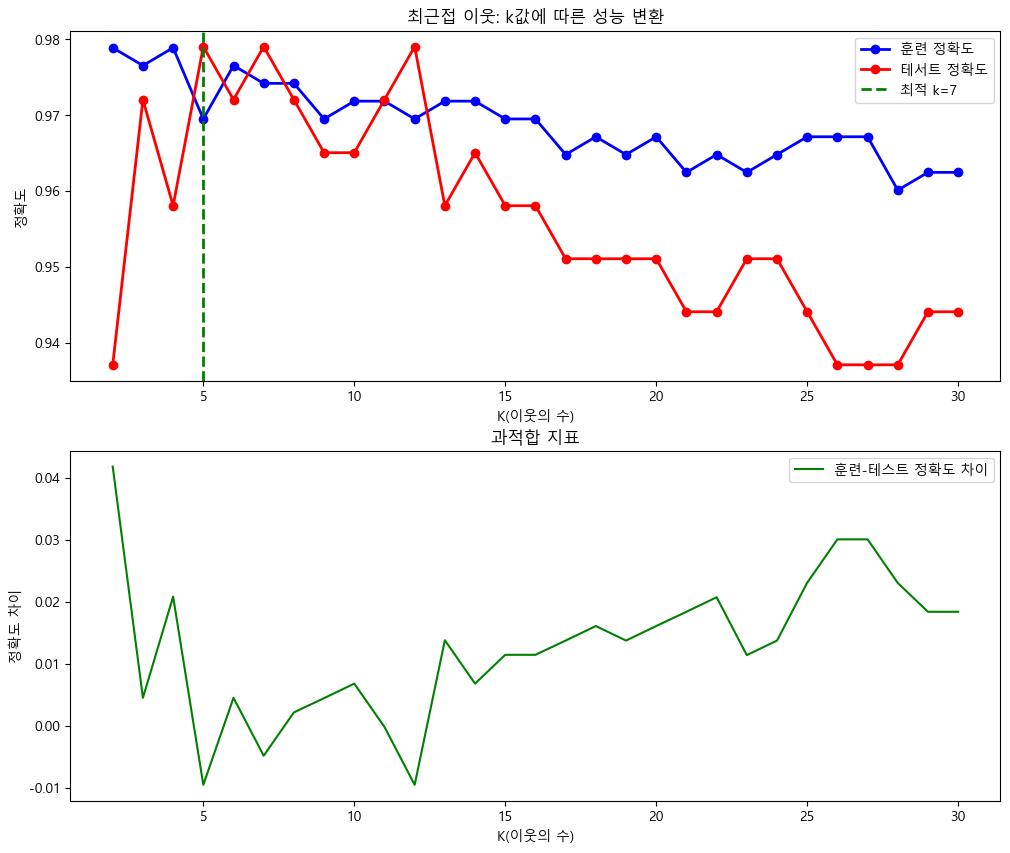

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))


# 정확도 곡선
ax1.plot(neighbors_settings, training_accuracy, 'o-', #중요
         label='훈련 정확도', linewidth=2, markersize=6, color='blue') #안중요 속성
ax1.plot(neighbors_settings, test_accuracy, 'o-', 
         label='테스트 정확도', linewidth=2, markersize=6, color='red')
ax1.axvline(x=best_k, color='green', linestyle='--', linewidth=2, label=f'최적 k={neighbors_settings[best_k]}') # 어디가 베스트인지
ax1.set_ylabel('정확도')
ax1.set_xlabel('K(이웃의 수)')
ax1.set_title('최근접 이웃: k값에 따른 성능 변환')
ax1.legend()

# 정확도 차이
accuracy_diff = np.array(training_accuracy) - np.array(test_accuracy)
ax2.plot(neighbors_settings, accuracy_diff, 'g-', label="훈련-테스트 정확도 차이")
ax2.set_ylabel('정확도 차이')
ax2.set_xlabel('K(이웃의 수)')
ax2.set_title('과적합 지표')
ax2.legend()


In [19]:
# 4. 학습 -> fit, predict
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [21]:
# 5. 검증 -> score..
print(knn.score( X_test, y_test))

0.951048951048951
